In [1]:
%pip install quandl

Note: you may need to restart the kernel to use updated packages.


In [125]:
import os
import quandl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

%matplotlib inline
directory = './saved_data'
quandl.ApiConfig.api_key = '6c6zAxUrHN7zKv4cG__z'
if not os.path.exists(directory):
    os.makedirs(directory)
    


# facebook data (check data quality)

In [156]:
data = quandl.get_table('SMA/FBD', brand_ticker = 'AAPL', paginate=True)
colnames = list(data)
for i in ['page_id','sector', 'geography']:
    colnames.remove(i)
data2 = data.loc[:,colnames]
data2 = data2.groupby('date').mean()
data2['brand_ticker'] = 'AAPL'

C:\Users\richard\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


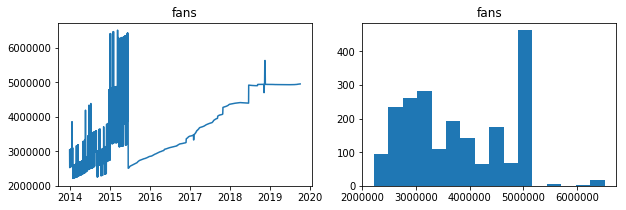

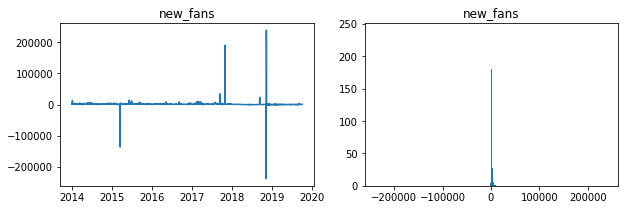

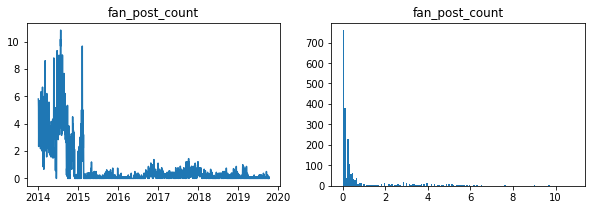

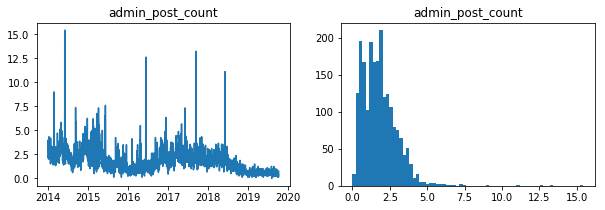

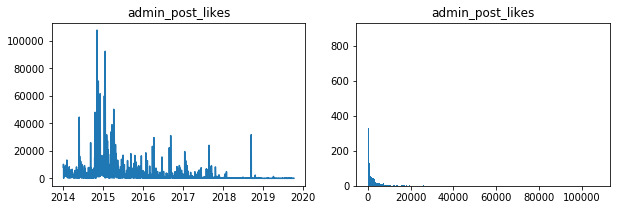

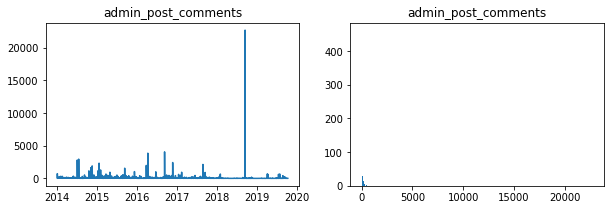

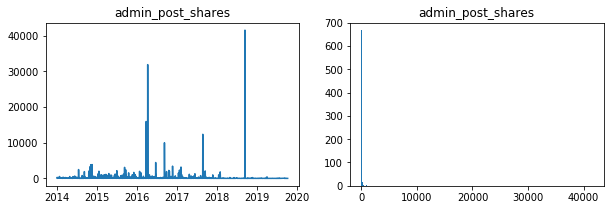

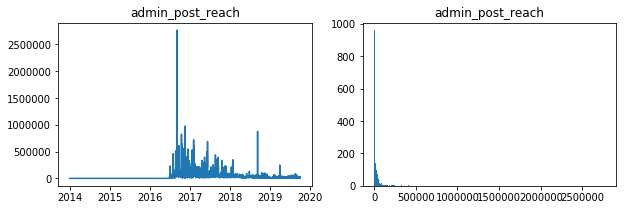

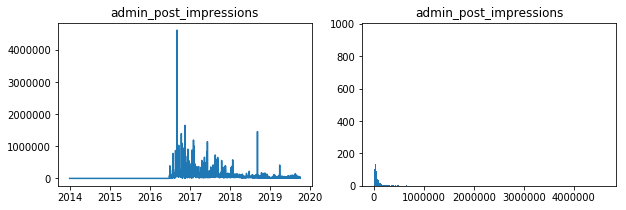

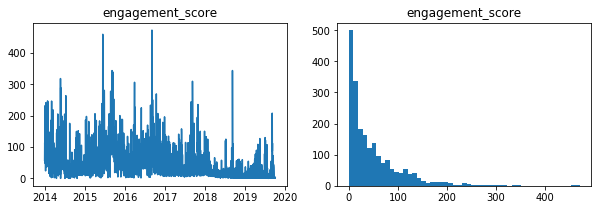

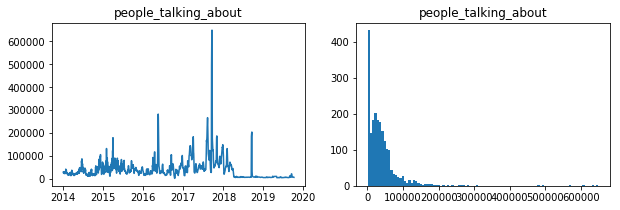

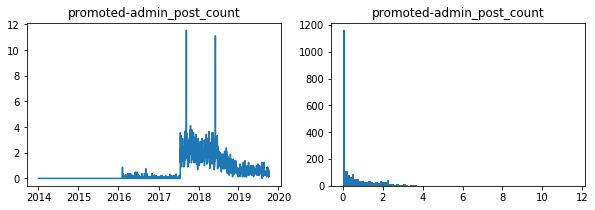

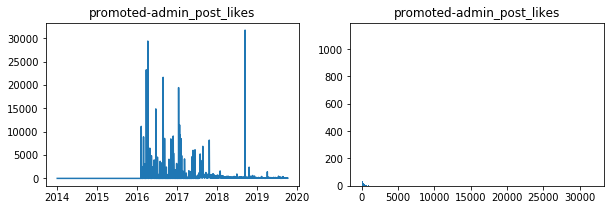

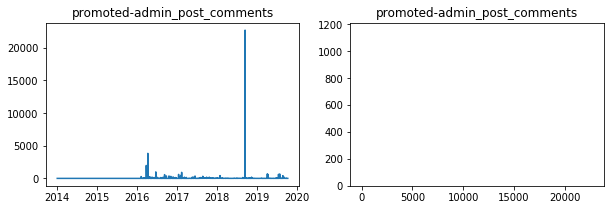

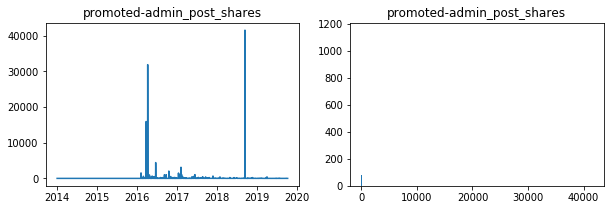

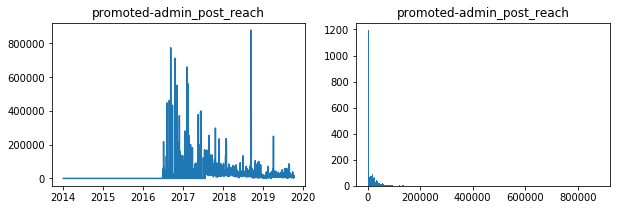

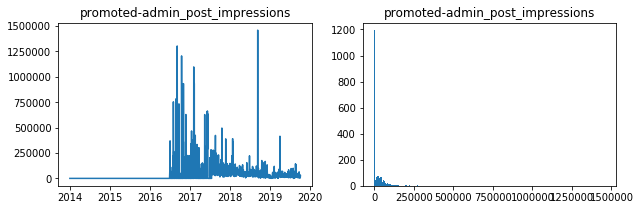

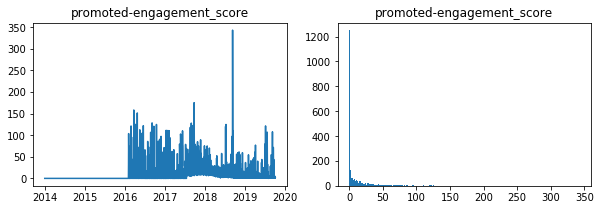

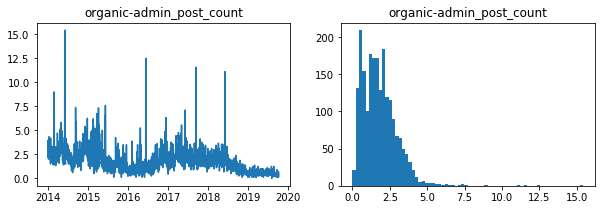

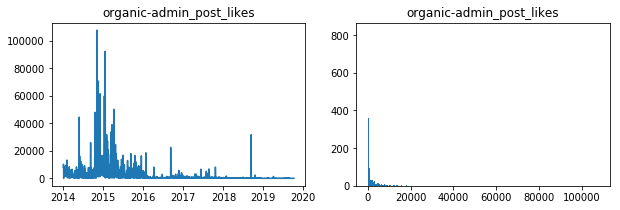

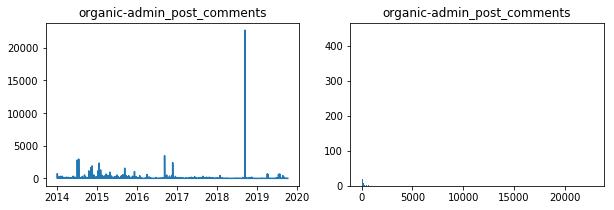

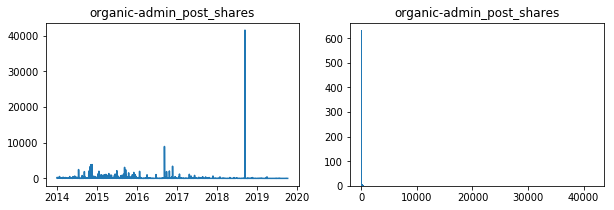

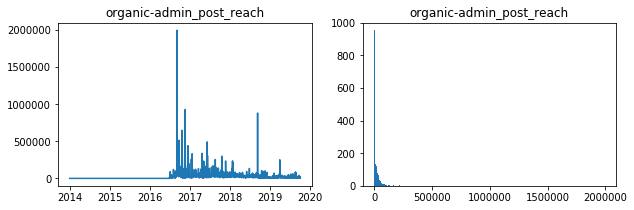

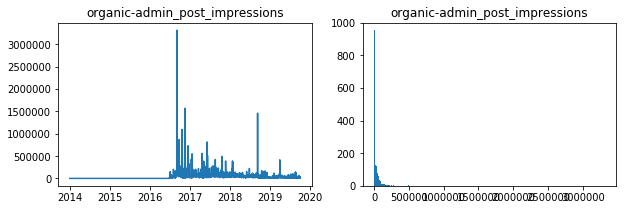

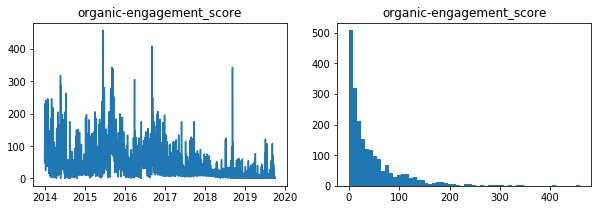

In [157]:
for i in list(data2)[:-1]:
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.plot(data2.loc[:,i])
    plt.title(i)
    plt.subplot(1,2,2)
    plt.hist(data2.loc[:,i], bins='auto')
    plt.title(i)    
plt.show()

So we keep ['fan_post_count','organic-admin_post_count','organic-admin_post_likes','organic-admin_post_comments','organic-admin_post_shares','organic-engagement_score']

Use PCA to reduce the dimension while keep the information

## write the code above into function

In [387]:
ticker='AAPL'
def get_facebook_daily(ticker='AAPL'):
    data = quandl.get_table('SMA/FBD', brand_ticker = ticker, paginate=True)
    colnames = list(data)
    for i in ['page_id','sector', 'geography']:
        colnames.remove(i)
    data2 = data.loc[:,colnames]
    data2 = data2.groupby('date').mean()
    data2['brand_ticker'] = ticker
    data2 = data2.loc[:,['organic-admin_post_count','organic-admin_post_likes','organic-admin_post_comments','organic-admin_post_shares','organic-engagement_score']]
    pca = PCA(n_components=1)
    
    
    # Use PCA to reduce the dimension while keep the information
    
    
    principalComponents = pca.fit_transform(data2.iloc[:,:-1])
    facebook_admin = pd.DataFrame(data = principalComponents
                 , columns = ['Facebook Analytics - Daily Metrics'])
    facebook_admin.index=data2.index
    facebook_admin['Facebook Analytics - Daily Metrics']=np.log(1+facebook_admin['Facebook Analytics - Daily Metrics'].values-min(facebook_admin['Facebook Analytics - Daily Metrics']))
    final_data=pd.concat([facebook_admin,data2.iloc[:,-1:]],axis=1)
    return final_data

def get_facebook_admin(ticker='AAPL'):
    data = quandl.get_table('SMA/FBP', brand_ticker = ticker, paginate=True)
    colnames = list(data)
    data2 = data.loc[:,['total-reactions','engagement_score','sentiment','date']]
    data2['sentiment']=data2['sentiment'].replace('POSITIVE',1)
    data2['sentiment']=data2['sentiment'].replace('NEGATIVE',-1)
    data2['sentiment']=data2['sentiment'].replace('NEUTRAL',0)
    data2['sentiment']=data2['sentiment'].replace('UNDEFINED',0)
    data2 = data2.groupby('date').mean()
    pca = PCA(n_components=1)
    principalComponents = pca.fit_transform(data2)
    facebook_admin = pd.DataFrame(data = principalComponents
                 , columns = ['Facebook Analytics - Admin Posts'],index=data2.index)   
    facebook_admin['Facebook Analytics - Admin Posts']=np.log(1+facebook_admin['Facebook Analytics - Admin Posts'].values-min(facebook_admin['Facebook Analytics - Admin Posts']))
    final_data=pd.concat([facebook_admin,data2.loc[:,['sentiment']]],axis=1)
    final_data=final_data.rename({'sentiment':'facebook admin sentiment'},axis=1)
    return final_data

def get_facebook_user(ticker='AAPL'):
    data = quandl.get_table('SMA/FBUP', brand_ticker = ticker, paginate=True)
    data2 = data.loc[:,['date','likes','comments','shares','sentiment']]
    data2['sentiment']=data2['sentiment'].replace('POSITIVE',1)
    data2['sentiment']=data2['sentiment'].replace('NEGATIVE',-1)
    data2['sentiment']=data2['sentiment'].replace('NEUTRAL',0)
    data2['sentiment']=data2['sentiment'].replace('UNDEFINED',0)
    data2 = data2.groupby('date').mean()
    pca = PCA(n_components=1)
    principalComponents = pca.fit_transform(data2)
    facebook_user = pd.DataFrame(data = principalComponents
                 , columns = ['Facebook Analytics - User Posts'],index=data2.index)   
    facebook_user['Facebook Analytics - User Posts']=np.log(1+facebook_user['Facebook Analytics - User Posts'].values-min(facebook_user['Facebook Analytics - User Posts']))
    final_data=pd.concat([facebook_user,data2.iloc[:,-1:]],axis=1)
    final_data=final_data.rename({'sentiment':'facebook user sentiment'},axis=1)
    return final_data

facebook_daily = get_facebook_daily(ticker)
facebook_admin = get_facebook_admin(ticker)
facebook_user  = get_facebook_user(ticker)

In [366]:
def getTwitterInstagramData(table,ticker):
    data=pd.DataFrame(quandl.get_table(table,brand_ticker=ticker,paginate=True))
    data=data.groupby("date").mean()
    
    pca = PCA(n_components=1)
    columns={
            "SMA/TWTD":["replies_count","retweets_count","brand_proactive_count"],
            "SMA/TWTT":["retweet_count","replies_count","favorite_count"],
            "SMA/INSD":["comments_count","likes_count"],
            "SMA/INSP":["comments_count","likes_count"]
        }
    names1={
        'SMA/TWTD':'TwiDaily PCA',
        'SMA/TWTT':'TwiTweet PCA',
        'SMA/INSP':'InsPosts PCA',
        'SMA/INSD':'InsDaily PCA'
    }
    names2={
        'SMA/TWTD':'TwiDaily engagement_score',
        'SMA/TWTT':'TwiTweet engagement_score',
        'SMA/INSP':'InsPosts engagement_score',
        'SMA/INSD':'InsDaily engagement_score'
    }
    pcadata=pca.fit_transform(data[columns.get(table)])

    pcadata=pd.DataFrame(data = pcadata
                 , columns = ["principal component"])
    pcadata.index=data.index
    pcadata=np.log(1+pcadata-np.min(pcadata))
    data_df=pd.concat([pcadata,data[["engagement_score"]]],sort=True,axis=1)
    data_df=data_df.rename({"principal component":names1[table],"engagement_score":names2[table]},axis=1)
    return data_df

In [367]:
InsDaily = getTwitterInstagramData('SMA/INSD',ticker)
InsPosts = getTwitterInstagramData('SMA/INSP',ticker)
TwiDaily = getTwitterInstagramData('SMA/TWTD',ticker)
TwiTweet = getTwitterInstagramData('SMA/TWTT',ticker)


In [393]:
print(np.shape(facebook_daily))
print(np.shape(facebook_admin)) 
print(np.shape(facebook_user)) # remvoe this one 

print(np.shape(InsDaily))
print(np.shape(InsPosts)) # remvoe this one 
print(np.shape(TwiDaily))
print(np.shape(TwiTweet))

(2106, 2)
(2103, 2)
(1351, 2)
(2106, 2)
(1870, 2)
(2106, 2)
(2101, 2)


In [398]:
final_df=facebook_daily.join(facebook_admin,how='outer').join(InsDaily,how='outer').join(TwiDaily,how='outer').join(TwiTweet,how='outer')

In [401]:
def interpolate_dataset(dataset):
    for ii,i in enumerate(dataset.index):
        for jj,j in enumerate(dataset):
            if str(dataset.iloc[ii,jj])=='nan':
                try:
                    if str(dataset.iloc[ii+1,jj])=='nan':
                        dataset.iloc[ii,jj]=dataset.iloc[ii-1,jj]
                    else:
                        dataset.iloc[ii,jj]=(dataset.iloc[ii-1,jj]+dataset.iloc[ii+1,jj])/2
                except:
                        dataset.iloc[ii,jj]=dataset.iloc[ii-1,jj]
    return dataset
final_df=interpolate_dataset(final_df)

In [402]:
final_df

,Facebook Analytics - Daily Metrics,organic-engagement_score,Facebook Analytics - Admin Posts,facebook admin sentiment,InsDaily PCA,InsDaily engagement_score,TwiDaily PCA,TwiDaily engagement_score,TwiTweet PCA,TwiTweet engagement_score
date,,,,,,,,,,
2014-01-01,8.998135,57.800000,8.208328,0.727273,10.097576,496.5,5.783886,166.666667,5.062437,163.875000
2014-01-02,9.234711,113.333333,7.843942,0.333333,11.235873,498.0,5.510158,156.666667,4.862481,172.555556
2014-01-03,9.063719,71.500000,7.962887,0.277778,11.476927,496.5,4.916147,128.666667,4.817946,188.166667
2014-01-04,4.775993,59.166667,3.942780,0.000000,11.348707,493.5,4.870315,84.000000,4.328116,109.375000
2014-01-05,8.558782,52.200000,7.863399,0.600000,10.972148,490.5,4.747260,90.333333,4.341823,91.000000
2014-01-06,8.173333,231.400000,7.175932,0.454545,11.163211,496.0,4.858447,69.666667,4.408814,110.285714
2014-01-07,8.538857,82.000000,7.763083,0.307692,0.000000,0.0,4.324679,144.666667,4.539490,119.500000
2014-01-08,7.734017,46.800000,6.850540,0.250000,10.516941,488.0,4.834874,87.000000,4.322529,100.000000
2014-01-09,8.421085,200.166667,6.948507,0.230769,11.634198,481.0,4.957115,135.333333,4.337274,118.600000


,Facebook Analytics - User Posts,sentiment
date,,
2014-01-01,0.198891,0.206897
2014-01-02,0.250881,0.000000
2014-01-03,0.171798,-0.032258
2014-01-04,0.057856,0.071429
2014-01-05,0.256293,0.166667
2014-01-06,0.577389,0.058824
2014-01-07,0.867976,0.000000
2014-01-08,0.705046,0.176471
2014-01-09,0.497901,0.066667
